# Decoding the representation of natural language from fMRI


*written by Jiwoong Park, Hayoung Song, and Won Mok Shim*


## Introduction

Decoding the natural language that represents semantic/narrative content from the neural activation patterns is a topic of interest in the field of cognitive neuroscience. By analyzing the linear relationship between functional MRI (fMRI) of multiple subjects and the corresponding movie annotations ([Vodrahali et al., 2018](https://doi.org/10.1016/j.neuroimage.2017.06.042)) or speech ([Huth et al., 2016](https://doi.org/10.1038/nature17637)), recent studies have shown that semantic or narrative content can be decoded from neural response patterns.  

In this tutorial, we introduce a method for decoding narrative content from fMRI data, by building a simple linear regression model.

### Tutorial goals
1. Learn how to convert natural language into a vector representation using a pretrained word embedding model
2. Learn how to decode natural language informaiton from fMRI data using a cross-validated, predictive model

## 1. Set up the running environment
### 1-1 Dataset description
We use the Paranoia dataset of [Finn et al. (2018)](https://www.nature.com/articles/s41467-018-04387-2). This dataset consists of 22 participants' fMRI data, as they listened to a 22-minute audio-narrated story. Each participant's fMRI data contains three runs. The goal is moment-to-moment decoding of the natural language information from the corresponding fMRI responses.

### 1-2 Load the modules

In [2]:
# Import libraries and configurations.
import re
import csv
import os
import pickle

# for scientific computing and data visualization 
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import zscore
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# for natural language processing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# for machine learning
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics.pairwise import cosine_similarity

# for handling neuroimaging data
import nibabel as nib
from nilearn import plotting


If you are using a high-DPI display (e.g., MacBook Pro), run the cell below. This allows you to plot high resolution figures.

In [3]:
%config InlineBackend.figure_format = 'retina'

You may need to download the `punkt` package if this is the first time you are using the NLTK tokenizer. After that, please run the cell below.

In [ ]:
import nltk
nltk.download('punkt') # Download package punkt if you don't have

In [42]:
# This code can raise the error.
# Please put this code to the first line of the cell if you don't want to run 
# Remove this cell if the tutorial is finalized

if True:
    raise Exception("Do not run!")

Exception: Do not run!

### 1-3 Download the Paranoia dataset (Note: Do not run!)
You can download the released Paranoia dataset from Datalad.
Run Unix commands using the `!` cell magic. Alternatively, you can use Python API of Datalad.

In [ ]:
if True:
    raise Exception("Do not run!")

!datalad clone https://gin.g-node.org/ljchang/Paranoia
    
# Download all preprocessed fMRI data
file_list = glob.glob(os.path.join('Paranoia', 'fmriprep', '*', 'func','*denoise*nii.gz'))
file_list.sort()
for file in file_list:
    print("Downloading...", file)
    !datalad get {file}


Concatenate the three runs into a single file using AFNI's 3dTcat function.

In [ ]:
if True:
    raise Exception("Do not run!")
    
sub_list = ['sub-tb2994','sub-tb3132','sub-tb3240','sub-tb3279','sub-tb3512',
            'sub-tb3592','sub-tb3602','sub-tb3626','sub-tb3646','sub-tb3744',
            'sub-tb3757','sub-tb3784','sub-tb3810','sub-tb3846','sub-tb3858',
            'sub-tb3920','sub-tb3929','sub-tb3964','sub-tb3977','sub-tb4450',
            'sub-tb4547','sub-tb4572']

output_dir = 'Paranoia_dataset/'
for sub in sub_list:
    sub_fname = glob.glob(os.path.join('Paranoia', 'fmriprep', sub, 'func','*denoise*nii.gz'))
    sub_fname.sort()
    print(sub_fname[0])
    print(sub_fname[1])
    print(sub_fname[2])
    !3dTcat {sub_fname[0]} {sub_fname[1]} {sub_fname[2]} -prefix {output_dir}{'sub-'+sub}.nii.gz

### 1-4 Data structure
Download the pretrained GloVe word embedding [here](https://nlp.stanford.edu/projects/glove/).

1. `Paranoia_dataset/sub-{id}.nii.gz`: Preprocessed fMRI data
2. `Glove/glove.6B.{#features}d.txt`: Pretrained GloVe word embedding
3. `ParanoiaStoryTranscript.csv`: Transcript for the Paranoia stimuli
4. `BN_2mm.nii.gz`: Brainnetome Atlas


In [5]:
!tree

.
├── BN_2mm.nii.gz
├── Glove
│   ├── glove.6B.100d.txt
│   ├── glove.6B.200d.txt
│   ├── glove.6B.300d.txt
│   └── glove.6B.50d.txt
├── ParanoiaStoryTranscript.csv
├── Paranoia_dataset
│   ├── sub-tb2994.nii.gz
│   ├── sub-tb3132.nii.gz
│   ├── sub-tb3240.nii.gz
│   ├── sub-tb3279.nii.gz
│   ├── sub-tb3512.nii.gz
│   ├── sub-tb3592.nii.gz
│   ├── sub-tb3602.nii.gz
│   ├── sub-tb3626.nii.gz
│   ├── sub-tb3646.nii.gz
│   ├── sub-tb3744.nii.gz
│   ├── sub-tb3757.nii.gz
│   ├── sub-tb3784.nii.gz
│   ├── sub-tb3810.nii.gz
│   ├── sub-tb3846.nii.gz
│   ├── sub-tb3858.nii.gz
│   ├── sub-tb3920.nii.gz
│   ├── sub-tb3929.nii.gz
│   ├── sub-tb3964.nii.gz
│   ├── sub-tb3977.nii.gz
│   ├── sub-tb4450.nii.gz
│   ├── sub-tb4547.nii.gz
│   └── sub-tb4572.nii.gz
├── Paranoia_parcellation.pkl
└── whole_brain-HSWS.ipynb

2 directories, 30 files


## 2. Functional MRI data
To reduce the fMRI data's dimensionality, we extract the mean time course of the regions of interest (ROIs), which is defined using the whole-brain parcellation of the Brainnetome Atlas (BNA) ([Fan. et al., 2016](http://doi.org/10.1093/cercor/bhw157)). The atlas contains 246 ROIs. Depending on the research purpose, other dimensionality reduction methods (e.g., PCA, ICA, SRM, etc.) can be chosen.

### 2-1. Brainnetome Atlas
Let's visualize the Brannetome Atlas. Here, we used the `nilearn` module (see details [here](https://nilearn.github.io))

If the library is not installed in your environment, please install it using `pip install nilearn`.


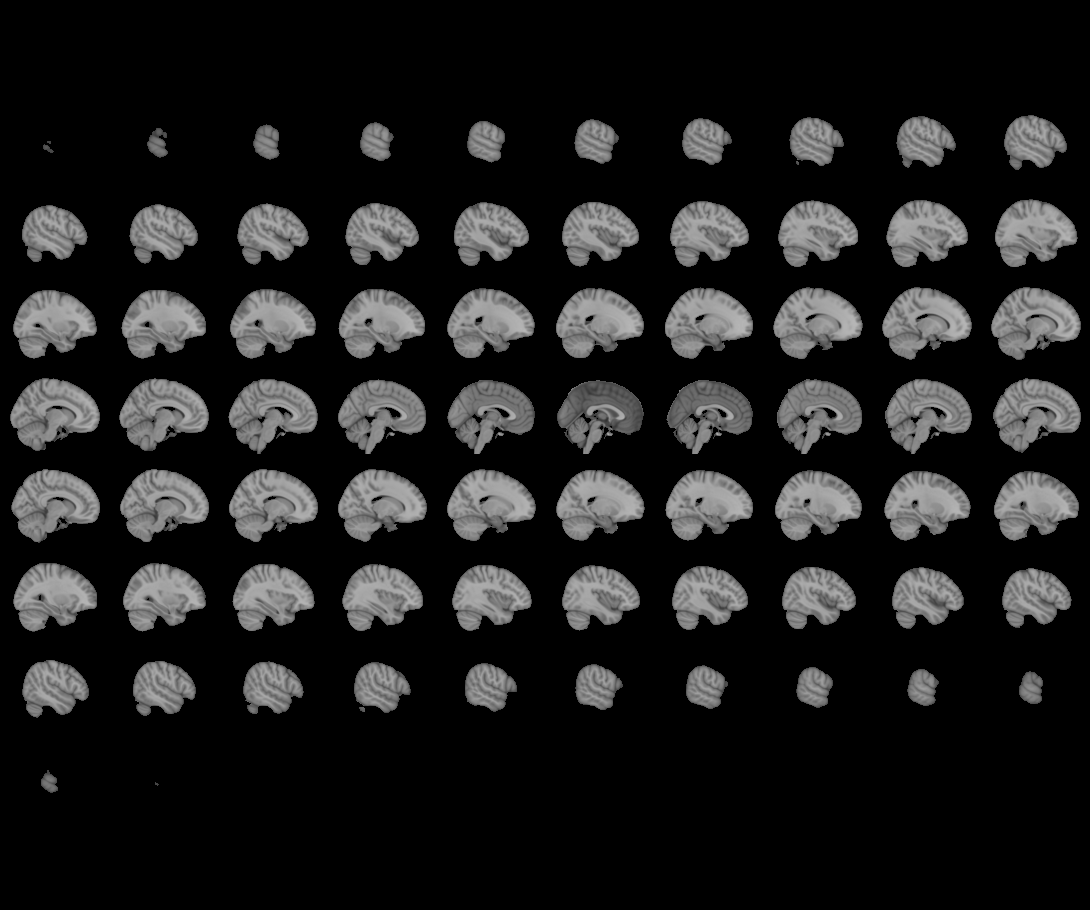
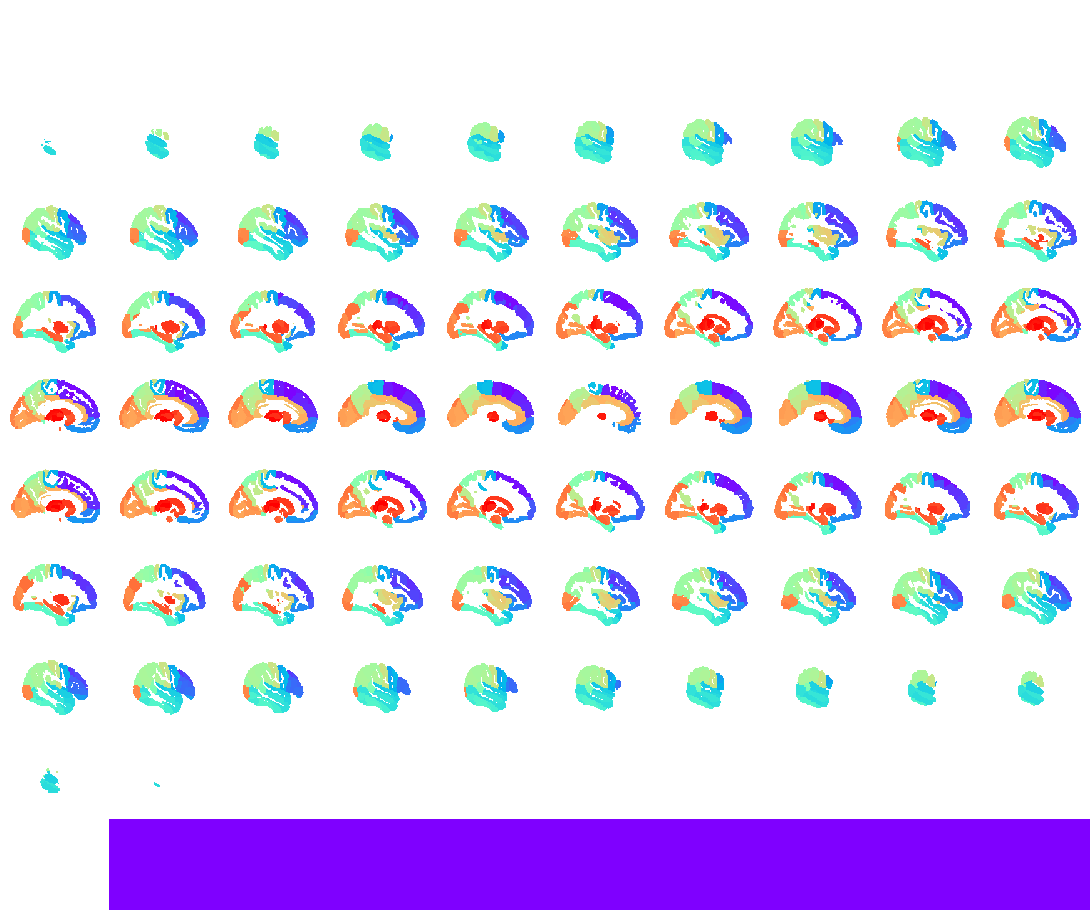

In [6]:
plotting.view_img('BN_2mm.nii.gz', symmetric_cmap=False, cmap='rainbow')

### 2-2. Mean time course of ROIs  (Note: Do not run!  Please run cell 2-3 for a test.)
Next, we will extract the mean time course from all voxels in each ROI.

The original fMRI data is 4D `(91, 109, 91, 1310)`, which corresponds to `(x, y, z, time)`. The Brainnetome Atlas has 246 ROIs, so the dimensions of the reduced data should be `(1310, 246)`. 

In [ ]:
if True:
    raise Exception("Do not run!")
    
sub_list = ['sub-tb2994','sub-tb3132','sub-tb3240','sub-tb3279','sub-tb3512',
            'sub-tb3592','sub-tb3602','sub-tb3626','sub-tb3646','sub-tb3744',
            'sub-tb3757','sub-tb3784','sub-tb3810','sub-tb3846','sub-tb3858',
            'sub-tb3920','sub-tb3929','sub-tb3964','sub-tb3977','sub-tb4450',
            'sub-tb4547','sub-tb4572']

BN_atlas = nib.load('BN_2mm.nii.gz').get_fdata()
fmri_data = []
for sub in sub_list:
    fmri_sub_fname = os.path.join('Paranoia_dataset', sub+'.nii.gz')
    print('#----------------------------------------------------------#')
    print('Loading ...', fmri_sub_fname)
    fmri_sub = nib.load(fmri_sub_fname).get_fdata()
    print('Shape of 4D fMRI data (x, y, z, time): ', fmri_sub.shape)
    
    fmri_parcellation = np.zeros((fmri_sub.shape[-1],246))
    for roi in range(1,247):
        fmri_parcellation[:,roi-1] = fmri_sub[BN_atlas==roi,:].mean(axis=0)
        
    print('Shape of parcellated fMRI data (time, ROIs):', fmri_parcellation.shape)
    fmri_data.append(fmri_parcellation)

Save your results! (Note: Remove this cell if the tutorial has been finalized.)

In [ ]:
if True:
    raise Exception("Do not run!")
    
with open('Paranoia_parcellation.pkl', 'wb') as f:
    pickle.dump(fmri_data, f)

### 2-3. Load the mean time course fMRI data  (Note: Remove this cell for final version.)

In [7]:
with open('Paranoia_parcellation.pkl', 'rb') as f:
    fmri_data = pickle.load(f)

### 2-3. Visualize fMRI data (Time points, ROIs)
Your fMRI data should now be a matrix of `(n_samples, n_features)`.

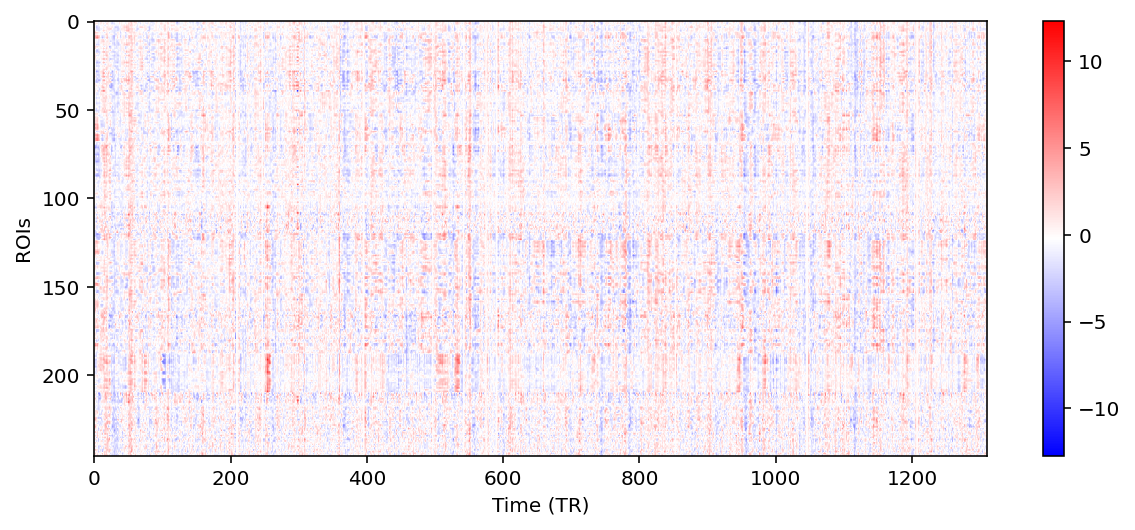

In [8]:
sub_num = 1 # Specify which subject you want to visualize. 
plt.figure(figsize=(10,4), facecolor='w')
# Transpose the matrix in order to put Time on the X axis.
plt.imshow(fmri_data[sub_num].T, aspect='auto', cmap='bwr')
plt.xlabel('Time (TR)')
plt.ylabel('ROIs')
plt.colorbar()

## 3. Word embedding

Next, we transform natural language information from the Paranoia transcript into vector representations using natural language processing (NLP) to represent the semantic meanings of the story quantitatively. To represent each word in the Paranoia stimuli, we use a pretrained word embedding model. The purpose is to project each word into a point in a multi-dimensional embedding space, so that it retains its semantic relationship with all other words. 

### 3-1. GloVe: Pretrained word embedding
The `GloVe: Global Vectors for Word Representation` is a widely used word embedding algorithm ([Pennington, Socher & Manning, 2014](https://nlp.stanford.edu/pubs/glove.pdf)). GloVe provides pretrained word vectors made from a variety of large corpus. You can check more information and download pretraiend models [here](https://nlp.stanford.edu/projects/glove/).
We will use the `glove.6B.100d.txt` model, which contains a feature dimensionality of 100.

In [47]:
# load the GloVe embedding
glove_file = open('Glove/glove.6B.100d.txt', 'r', encoding='utf-8')
pre_glove_100 = {}
for line in glove_file:
    splitLine = line.split()
    glove_words = splitLine[0]
    glove_vectors = np.array([float(val) for val in splitLine[1:]])
    pre_glove_100[glove_words] = glove_vectors
    
# Usage: pre_glove_100['test_word']

If a vector representation of each word reflects its semantic information, semantically similar words should have similar vector representations. 

Now we will check what they look like.

shape of the word vector [cheese] is:  (100,)


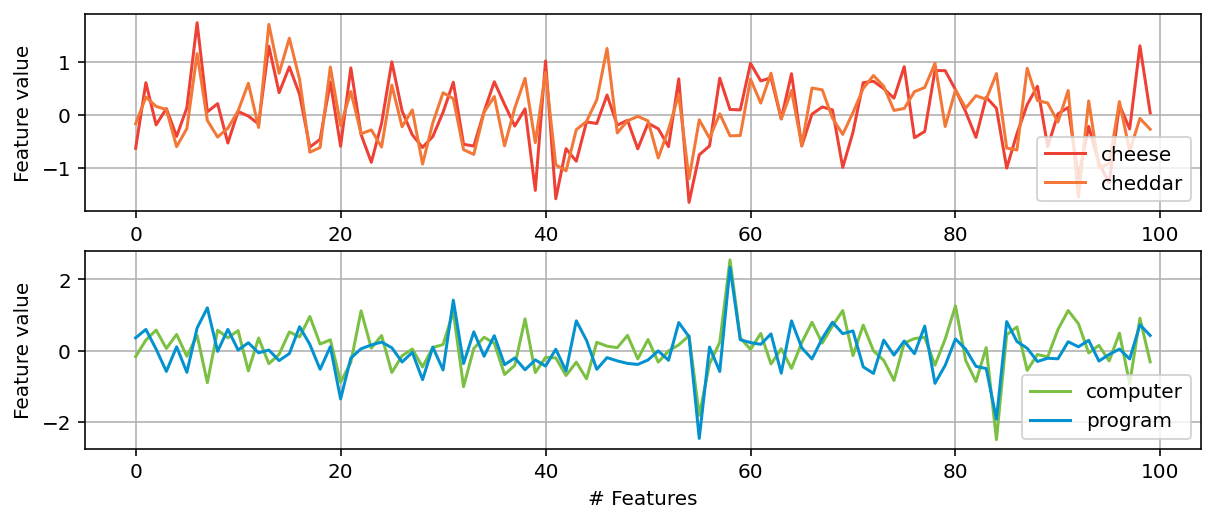

In [48]:
vector_of_cheese = pre_glove_100['cheese']                                                                           
print("shape of the word vector [cheese] is: ", vector_of_cheese.shape)

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(pre_glove_100['cheese'].ravel(), c='#ee4035', label='cheese')
plt.plot(pre_glove_100['cheddar'].ravel(), c='#f37736', label='cheddar')
plt.legend(loc='lower right')
plt.ylabel('Feature value')
plt.grid()

plt.subplot(2,1,2)
plt.plot(pre_glove_100['computer'].ravel(), c='#7bc043', label='computer')
plt.plot(pre_glove_100['program'].ravel(), c='#0392cf', label='program')
plt.legend(loc='lower right')
plt.ylabel('Feature value')
plt.xlabel('# Features')
plt.grid()

### 3-2. Preprocessing the Paranoia transcript
The file `ParanoiaStoryTranscript.csv` contains all sentences included in the transcript, as well as their attached time stamps. In this step, we will apply basic data cleaning and preprocessing to the words before projecting them into the embedding space.

In [49]:
wordnet_lemmatizer = WordNetLemmatizer() 

paranoia_transcript_fname = 'ParanoiaStoryTranscript.csv'
paranoia_words = pd.DataFrame(columns=['onset', 'offset', 'words'])

onset_time = 0
with open(paranoia_transcript_fname, 'r', encoding="utf-8") as csvFile:
    reader = csv.reader(csvFile)
    next(reader) # Remove the first line (name of each column)
    # Columns info:   0: Run number 
    #                 1: Event number
    #                 2: Sentence number
    #                 3: Time offset
    #                 4: Sentence transcript
    
    #----- Natural Language pre-processing steps -----#
    for i, row in enumerate(reader):
        sent = row[4]                               # Column #4: Sentence transcript
        sent = re.sub(r"[^A-Za-z ']+", '', sent)    # Remove unnecessary characters
        sent = sent.lower()                         # Convert it to lowercase
        words = word_tokenize(sent)                 # Tokenization
        
        paranoia_words.loc[i] = [int(onset_time), int(row[3]), words] # append "onset", "offset", "words"
        
        onset_time = row[3]
        
        
print('-----------------------Paranoia transcript-----------------------')
print(paranoia_words)
print(' ')

-----------------------Paranoia transcript-----------------------
    onset offset                                              words
0       0      2                                                 []
1       2     13  [the, email, came, late, one, afternoon, as, d...
2      13     20  [it, had, been, a, long, day, at, the, busy, c...
3      20     25  [but, the, emails, strange, subject, line, cau...
4      25     28              [fellow, doctor, i, need, your, help]
..    ...    ...                                                ...
244  1283   1290  [but, another, part, of, her, felt, wracked, w...
245  1290   1294    [carmen, pictured, albas, wide, trusting, eyes]
246  1294   1298  [if, she, left, now, the, decision, would, hau...
247  1298   1306  [on, the, other, hand, she, was, n't, even, su...
248  1306   1310                    [what, was, she, going, to, do]

[249 rows x 3 columns]
 


So now, we have 249 sentences, along with their onset and offset times.

To map this to the fMRI data, the data matrix should be (1310, 100), which corresponds to (number of TRs, number of features).

You could simply take the average of the embedding vectors of all words in each sentence, then assign this average vector for the duration of the corresponding sentence (from onset to offset).

However, because the participants listened to each word in the audio-narrated story in order, we can adopt a more reasonable method from [Huth et al. (2016)](https://doi.org/10.1038/nature17637), in which they placed each word vector at the onset time of the corresponding word and downsampled the data points to match the fMRI data's low temporal resolution. 

Because the Paranoia dataset does not contain the time stamps for when each word occurred, let us assume that the words in a sentence are distributed evenly for the duration of the sentence. *For example, if a sentence of 6 words is delivered over the course of 3 seconds, we can assume that the interval between each words is a half second.*

In addition, words that cannot be projected into the GloVe embedding space (e.g., proper nouns) are ignored.

In [50]:
word_list = []
word_time = []
word_embedding = []

error_keys = []
paranoia_words['words']
for i in range(paranoia_words.shape[0]):
    onset = paranoia_words.loc[i]['onset']
    duration = paranoia_words.loc[i]['offset'] - onset
    num_words = len(paranoia_words.loc[i]['words'])
    if num_words == 0:
        word_list.append('') # Add zero vectors for empty time points
        word_time.append(onset)
        word_embedding.append(np.zeros(100))
    else:
        for j, words in enumerate(paranoia_words.loc[i]['words']):
            try:   # Check if the word can be projected
                word_embedding.append(pre_glove_100[words])
                valid = True
            except KeyError:  
                valid = False
                error_keys.append(words) # Ignored words
                
            if valid:
                word_list.append(words)
                word_time.append(onset+duration*(j/num_words)) #
                
word_time = np.array(word_time)
word_embedding = np.array(word_embedding)
print('Word embedding (words, features): ', word_embedding.shape)
print(' ')
print('------------------Error keys(cannot be embedded)-----------------')
print(error_keys)



Word embedding (words, features):  (3451, 100)
 
------------------Error keys(cannot be embedded)-----------------
['torreson', 'torreson', 'carmens', 'torreson', 'torreson', 'torreson', 'torreson', 'carmens', 'carmens', 'carmens', 'flipflops', 'oldfashioned', 'torreson', 'torreson', 'seor', 'torreson', 'carmens', 'carmens', 'carmens', 'torreson', 'carmens', 'offlimits', 'werent', 'torreson', 'familys', 'familys', 'antifever']


### 3-3. Resampling the word vectors
We now have 3451 word vectors in an embedding dimension of 100. Let us visualize the process of resampling using the first 100 words on the first feature dimension.

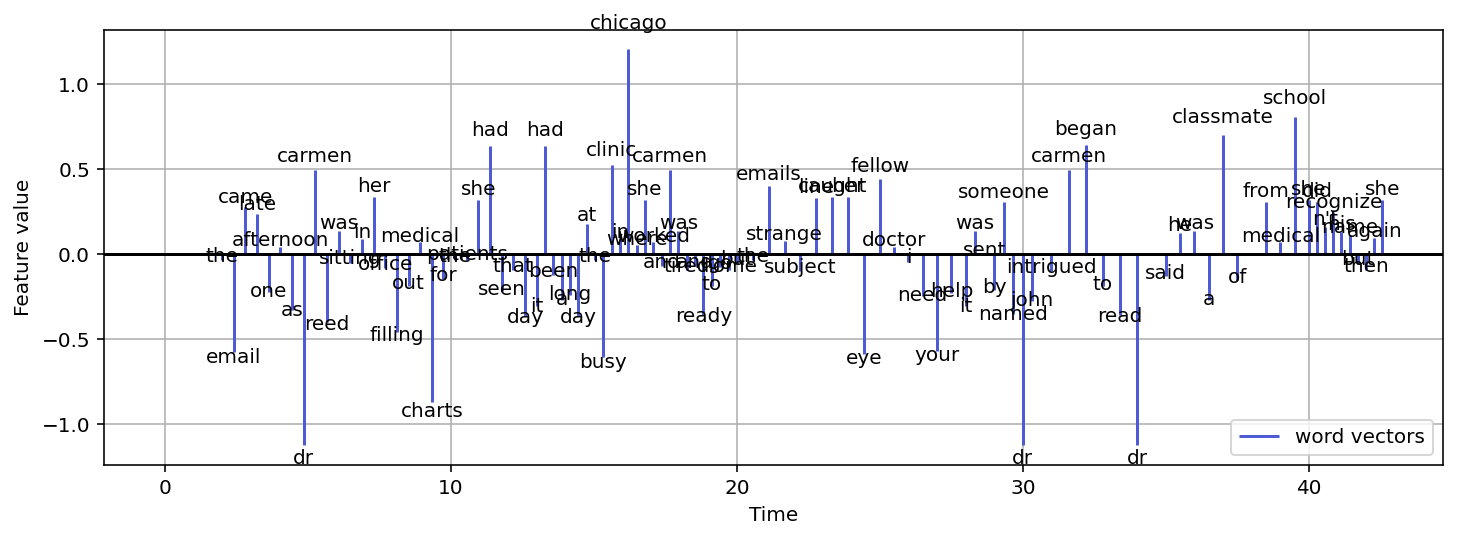

In [43]:
n_words = 100   # first 100 words
feature = 0     # first feature

plt.figure(figsize=(12,4))
plt.axhline(0, c='k')
plt.vlines(word_time[:n_words], [0], 
           word_embedding[:n_words, feature], color='#4f5bd5', label='word vectors')
# The blue peak represents each word

for i in range(n_words):
    plt.text(word_time[i], 1.1*word_embedding[i, feature], s=word_list[i], ha='center')

plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Feature value')
plt.grid()

Next, we need to downsample the word vector to the scale of the fMRI data. Here, we use a linear interpolation function. The red line represents the downsampled signal. 

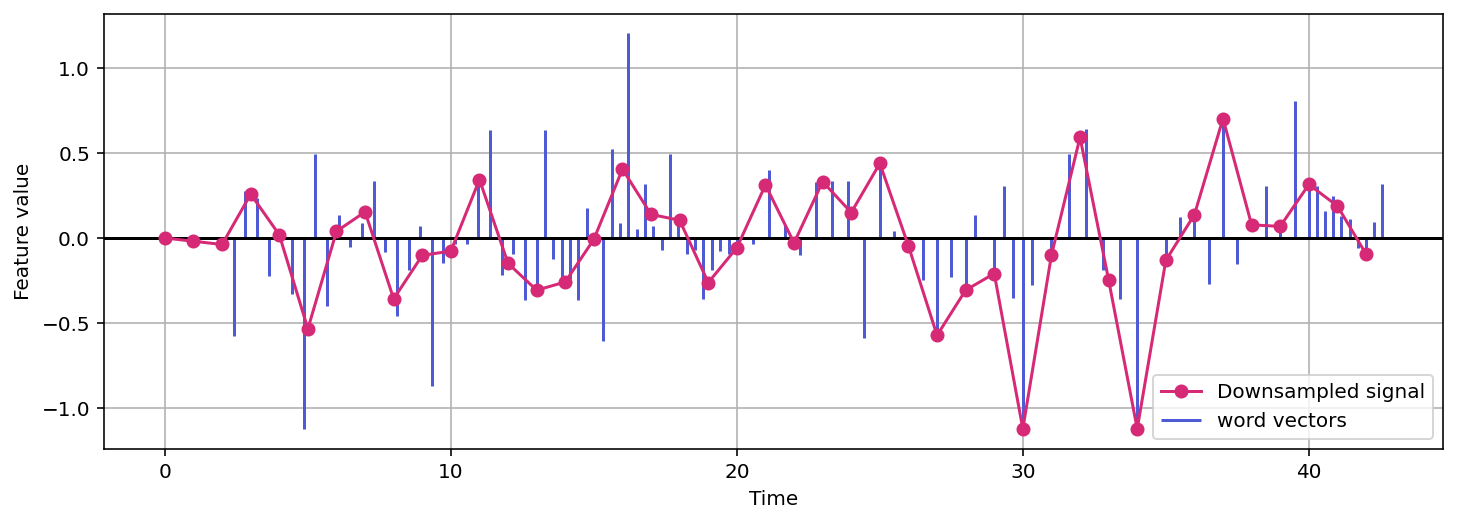

In [14]:
plt.figure(figsize=(12,4))
plt.axhline(0, c='k')
plt.vlines(word_time[:n_words], [0], 
           word_embedding[:n_words, feature], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_time[:n_words], 
                             word_embedding[:n_words, feature], kind='linear')

TR_time = np.arange(43) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Feature value')
plt.grid()

Finally, we convolve this downsampled signal with the hemodynamic response function (HRF) to obtain temporally lagged fMRI responses. 

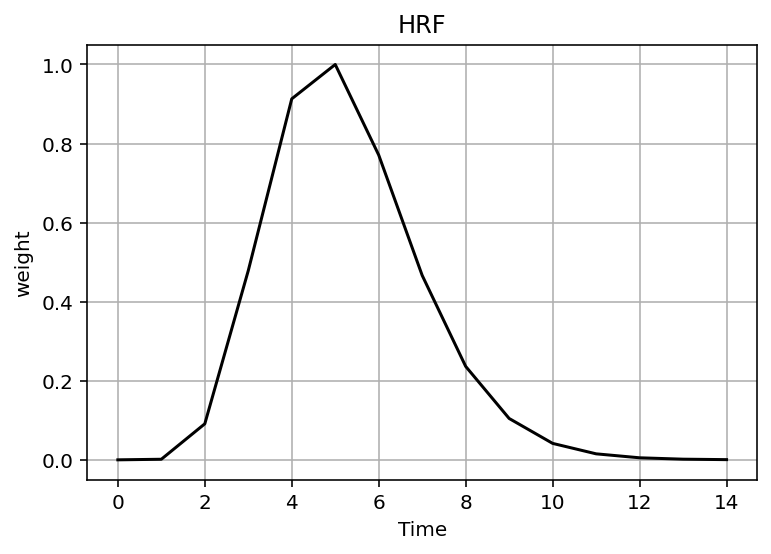

In [15]:
# HRF model
def HRF(t):
    signal = t ** 8.6 * np.exp(-t / 0.547)
    return signal/np.max(signal)
hrf_weight = HRF(np.arange(0, 15, 1))

def HRFconvolve(vector, weight):
    hrf_vector = np.convolve(vector, weight)
    hrf_vector = hrf_vector[0:len(vector)]
    return hrf_vector

plt.figure(figsize=(6,4))
plt.plot(hrf_weight, 'k-')
plt.ylabel('weight')
plt.xlabel('Time')
plt.title('HRF')
plt.grid()

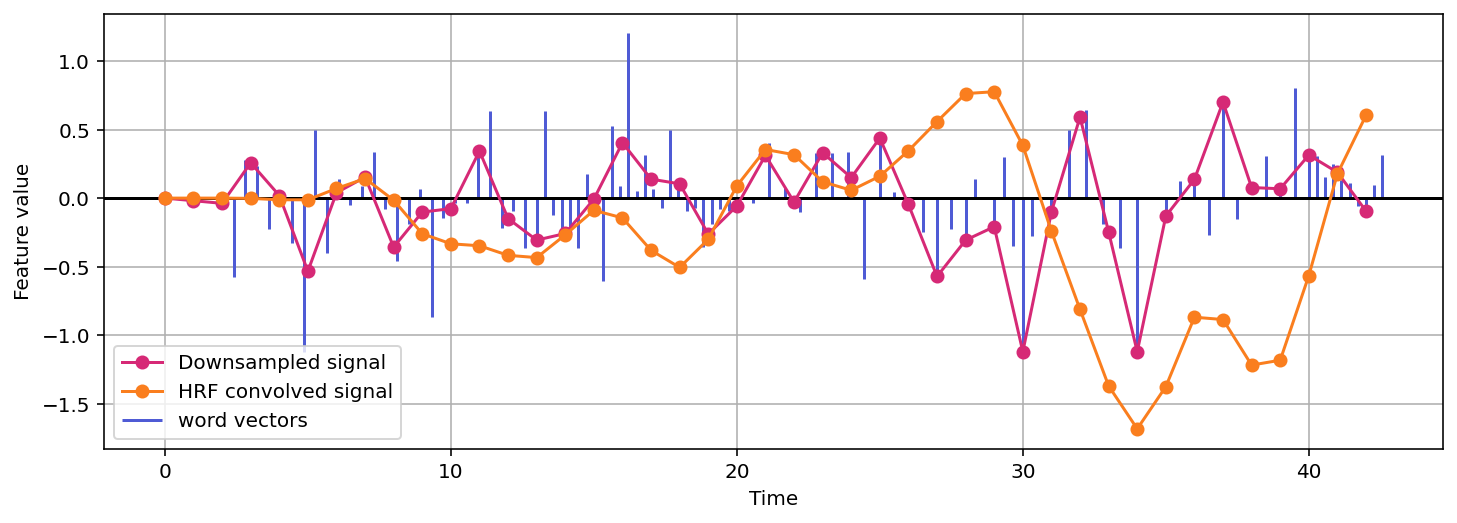

In [16]:
plt.figure(figsize=(12,4))
plt.axhline(0, c='k')
plt.vlines(word_time[:n_words], [0], 
           word_embedding[:n_words, feature], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_time[:n_words], 
                             word_embedding[:n_words, feature], kind='linear')

TR_time = np.arange(43) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

# Convolve HRF
HR_vector = HRFconvolve(downsampled_vector, hrf_weight)
plt.plot(TR_time, HR_vector, 'o-',color='#fa7e1e', label='HRF convolved signal')

plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Feature value')
plt.grid()

Apply the steps above to all features in the embedding space.

In [17]:
n_TR = 1310
n_Feature = 100
downsample_embedding = np.zeros((n_TR,n_Feature))
paranoia_embedding = np.zeros((n_TR,n_Feature))
for i in range(n_Feature):
    linear_downsample = interp1d(word_time, word_embedding[:,i])
    TR_time = np.arange(n_TR)

    downsampled_vector = linear_downsample(TR_time)
    paranoia_embedding[:,i] = HRFconvolve(downsampled_vector, hrf_weight)

## 4. Linear decoding model
### 4-1. Decoding natural language from the fMRI data (using cross-validation across subjects)
Finally, we have the fMRI data of (1310, 246), and the natural language data of (1310, 100). 

We use a linear model to learn the relationship between the fMRI responses and word embeddings computed from the Paranoia transcript. To do this, we employ a leave-one-subject-out cross-validation approach. In other words, we train a linear model with all time points for all subjects but one and test the model on the held-out participants' fMRI time course. The fMRI responses (x) are different for the 22 participants, but the word embedding time course (y) is the same.  

We predict the word embedding vector of each time point and measure its similarity (i.e., cosine similarity) with the observed vector. The decoding is succssful if the similarity between the predicted and corresponding observed word vectors is ranked within the top-N over the similarities bewteen the predicted and observed word vectors at all other time steps. Here, we use top-10, meaning the decoding is successful if the similarity between the predicted and observed vectors is within a rank of 10 over 1310 other possible observed vectors. Thus, the chance level is 10 / 1310 * 100 = 0.763%.

In [44]:
sub_list = ['sub-tb2994','sub-tb3132','sub-tb3240','sub-tb3279','sub-tb3512',
            'sub-tb3592','sub-tb3602','sub-tb3626','sub-tb3646','sub-tb3744',
            'sub-tb3757','sub-tb3784','sub-tb3810','sub-tb3846','sub-tb3858',
            'sub-tb3920','sub-tb3929','sub-tb3964','sub-tb3977','sub-tb4450',
            'sub-tb4547','sub-tb4572']

X = fmri_data
Y = zscore(paranoia_embedding, axis=0) # Normalize each feature dimension

n_top = 10
LOO = LeaveOneOut()

test_hit = []
test_similarity = []
map_coef = []

# Leave one subject out cross validation
for train_index, test_index in LOO.split(sub_list):
    print("TRAIN sub:", train_index, "TEST sub:", test_index)
    X_train = np.zeros((1310*len(train_index), 246))   # Train X(fMRI): (1310*21, 246)
    y_train = np.zeros((1310*len(train_index), 100))   # Train Y(Text): (1310*21, 100)
    for i, idx in enumerate(train_index):
        X_train[i*1310:(i+1)*1310, :] = X[idx]
        y_train[i*1310:(i+1)*1310, :] = Y
    X_test = X[test_index[0]]                          # Test X(fMRI): (1310, 246)
    y_test = Y                                         # Test Y(Text): (1310, 100)
    
    reg = LinearRegression().fit(X_train, y_train)
    map_coef.append(reg.coef_)
    y_pred = reg.predict(X_test)
    similarity = cosine_similarity(y_pred, y_test)
    test_similarity.append(similarity)
    
    # Check if the predicted word embedding is ranked within the top 10
    hit = 0
    for j in range(similarity.shape[0]):        
        if j in similarity[j,:].argsort()[-n_top:][::-1]:
            hit += 1
    print('Test decoding acc.: {:0.3f}%'.format(100*hit/1310))
    print(' ')

    test_hit.append(hit)
test_similarity = np.array(test_similarity)
print(' ')
print('----------------------Average decoding acc.----------------------')
print('Average acc.: {:0.3f}%'.format((100*np.array(test_hit)/1310).mean()))
print('Chance acc.: {:0.3f}%'.format(n_top / 1310 * 100))
map_coef = np.mean(map_coef, axis=0)

TRAIN sub: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [0]
Test decoding acc.: 4.504%
 
TRAIN sub: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [1]
Test decoding acc.: 3.817%
 
TRAIN sub: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [2]
Test decoding acc.: 2.901%
 
TRAIN sub: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [3]
Test decoding acc.: 3.893%
 
TRAIN sub: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [4]
Test decoding acc.: 3.664%
 
TRAIN sub: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [5]
Test decoding acc.: 3.359%
 
TRAIN sub: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [6]
Test decoding acc.: 1.985%
 
TRAIN sub: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [7]
Test decoding acc.: 3.740%
 
TRAIN sub: [ 0  1  2  3  4  5  6  7  9 10 11 12 

Next, we will visualize the similarity between the predicted and observed word vectors for all time points (averaged across subjects). For the decoding to be successful, the similarity between the predicted and observed vectors should be higher than the similarity between the predicted and the other observed vectors at the rest of the time points. This should result in the higher diagonal values than the non-diagonal ones in the left figure. The right figure indicates the locations of the top 10 predicted indices.

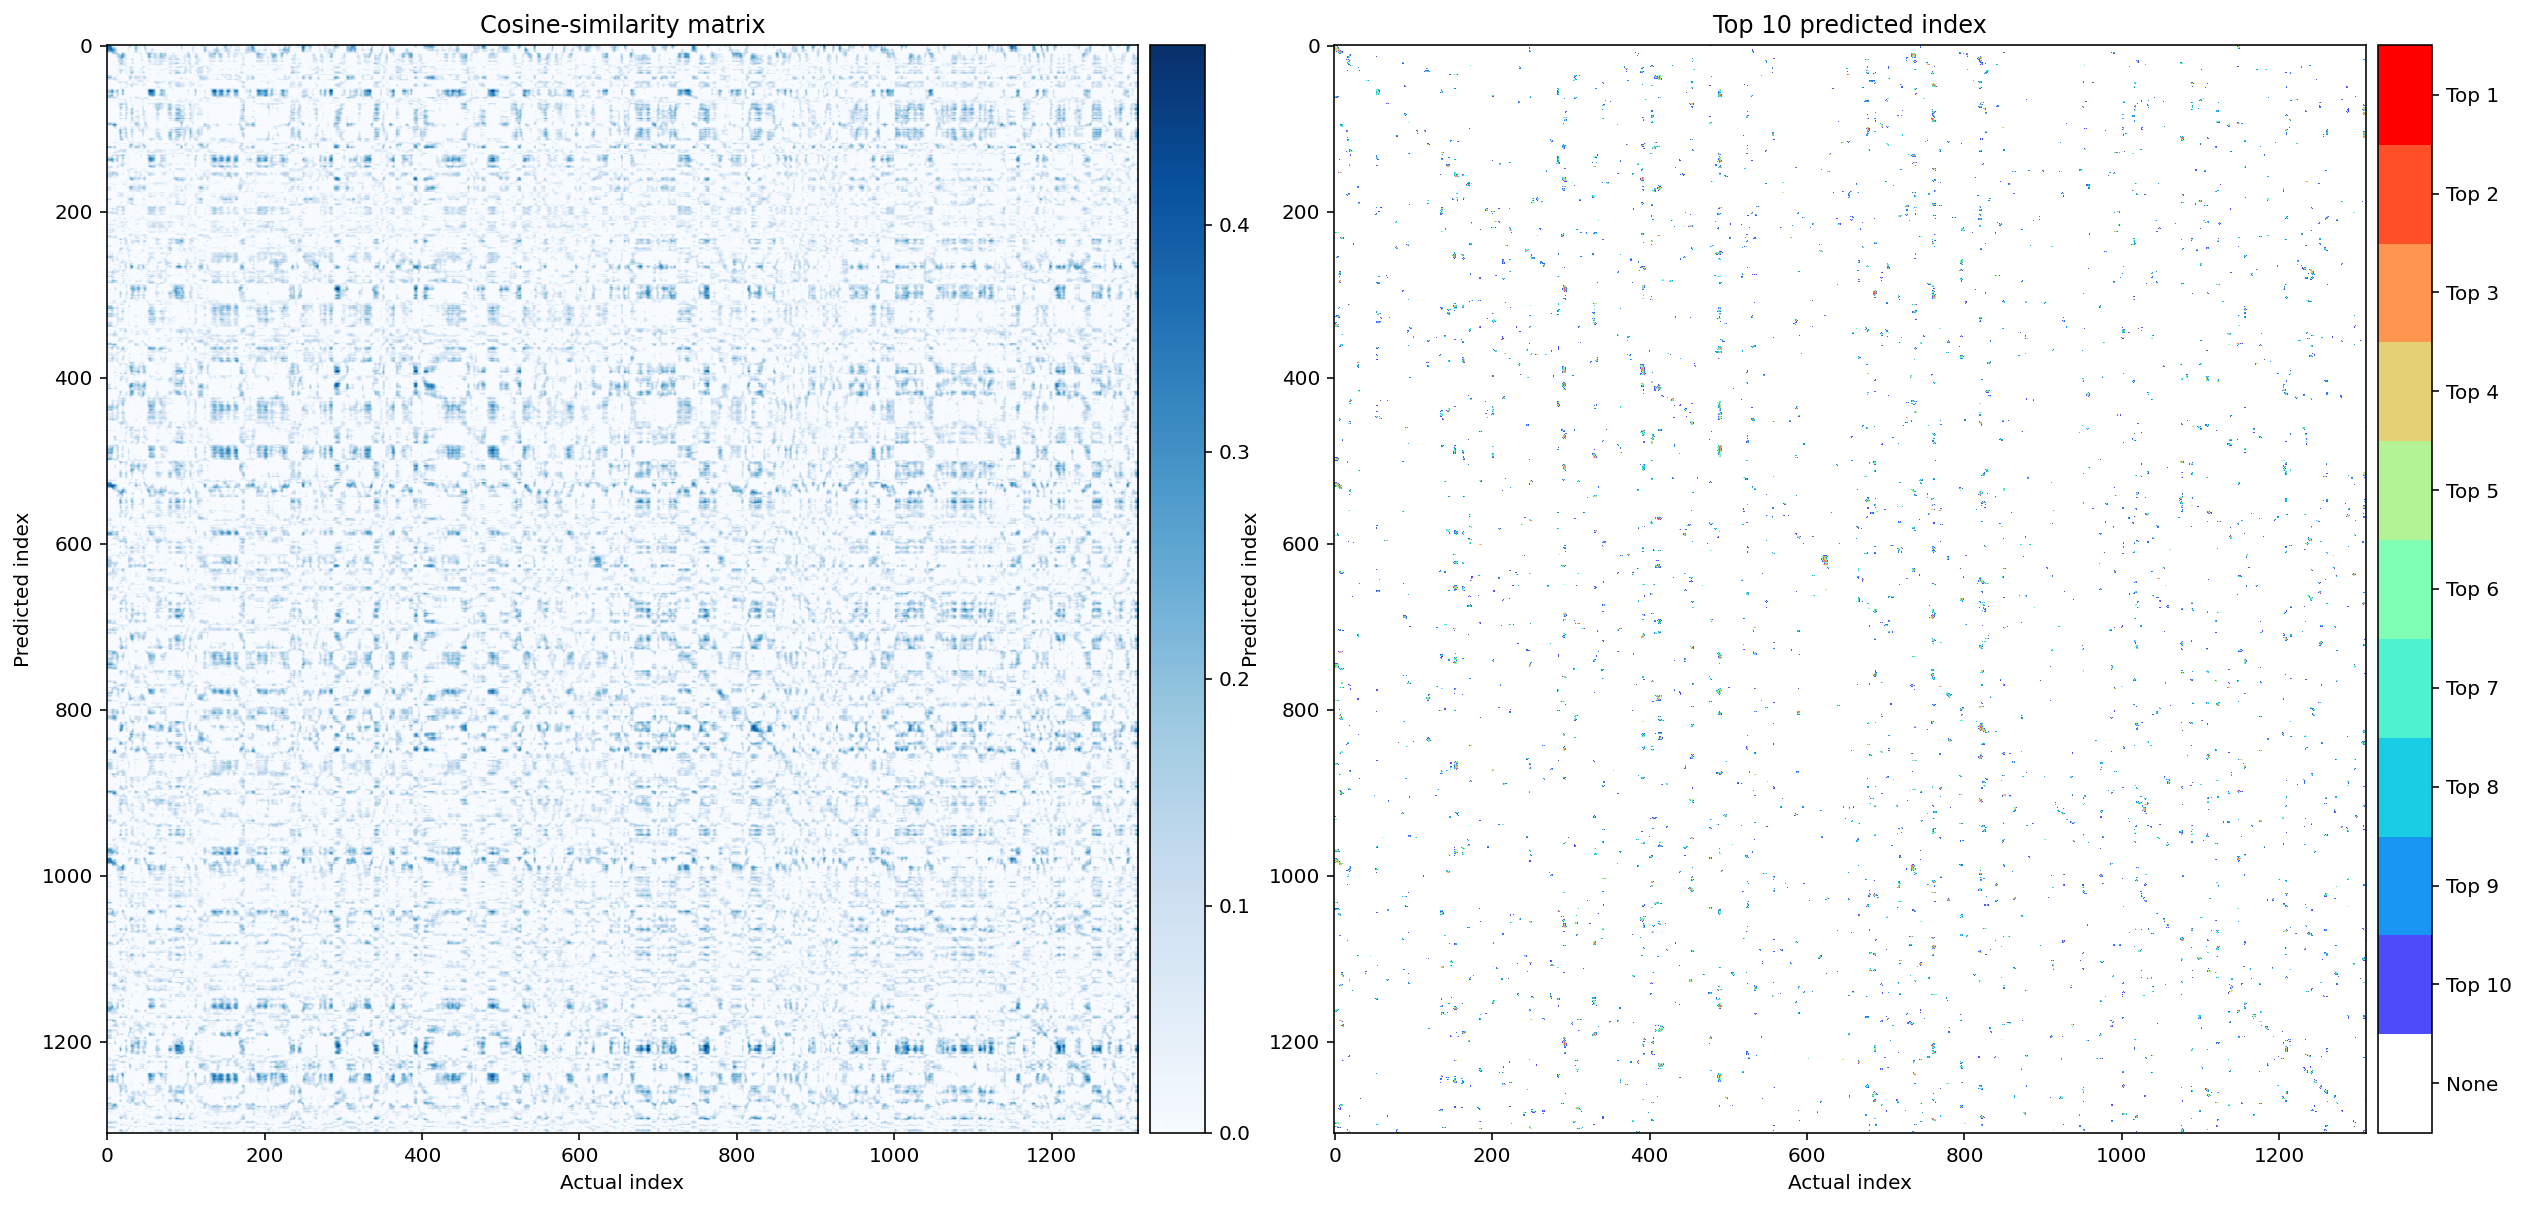

In [19]:
from matplotlib import colors, cm

cmap = cm.rainbow
cmaplist = [cmap(i) for i in range(cm.rainbow.N)]
cmaplist[0] = (1.0,1.0,1.0,1.0)
my_cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

n_top = 10
norm = colors.BoundaryNorm(np.arange(n_top+2), 256)
hit = 0

similarity = test_similarity.mean(axis=0)
hit_matrix = np.zeros(similarity.shape)
for j in range(similarity.shape[0]):
    for k, idx in enumerate(similarity[j,:].argsort()[-n_top:][::-1]):
        hit_matrix[j,idx] = n_top-k
        if j == k:
            hit +1
            
plt.figure(figsize=(22,10), facecolor='w')
plt.subplots_adjust(wspace=0.0)
plt.subplot(121)
plt.imshow(similarity, aspect='auto', cmap='Blues')
plt.ylabel('Predicted index')
plt.xlabel('Actual index')
plt.colorbar(pad=0.01)
plt.clim(0,None)
plt.title('Cosine-similarity matrix')

plt.subplot(122)
plt.imshow(hit_matrix, aspect='auto', cmap=my_cmap, norm=norm)
plt.ylabel('Predicted index')
plt.xlabel('Actual index')
cb = plt.colorbar(pad=0.01)

labels = np.arange(0,11,1)
loc    = labels + .5
cb.set_ticks(loc)
cb.set_ticklabels(['None']+['Top '+str(n_top-l) for l in labels[:-1]])
plt.title('Top 10 predicted index')

plt.show()

### 4-2. Decoding scrambled words from fMRI (for baseline)
We will now create a baseline to check whether our model performance is specific to fMRI-text mapping. To do this, we scramble the order of the words in the story and relate them with the fMRI responses using the same linear mapping procedure. 

In [51]:
n_top = 10
n_iter = 20
scram_hit_iter = []
for iter in range(n_iter): # Number of iterations
    
    # Scramble the order of the words
    word_embedding_scram = np.array(word_embedding)[np.random.permutation(3451),:]
    paranoia_embedding_scram = np.zeros((n_TR,n_Feature))
    
    # Downsample and HRF convolve
    for i in range(n_Feature):
        linear_downsample = interp1d(word_time, word_embedding_scram[:,i])
        TR_time = np.arange(n_TR)
        downsampled_vector = linear_downsample(TR_time)
        paranoia_embedding_scram[:,i] = HRFconvolve(downsampled_vector, hrf_weight)
    
    # Same linear mapping between the fMRI and scrambled word embeddings
    X = fmri_data
    Y = zscore(paranoia_embedding_scram, axis=0)
    
    scram_hit = []
    for train_index, test_index in LOO.split(sub_list):
        X_train = np.zeros((1310*len(train_index), 246))
        y_train = np.zeros((1310*len(train_index), 100))
        for i, idx in enumerate(train_index):
            X_train[i*1310:(i+1)*1310, :] = X[idx]
            y_train[i*1310:(i+1)*1310, :] = Y
        X_test = X[test_index[0]]
        y_test = Y

        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        similarity = cosine_similarity(y_pred, y_test)
        hit = 0
        for j in range(similarity.shape[0]):
            if j in similarity[j,:].argsort()[-n_top:][::-1]:
                hit += 1
        scram_hit.append(hit)
    scram_hit_iter.append(100*np.array(scram_hit)/1310)

scram_hit_iter = np.array(scram_hit_iter)  

print('-----------------Average decoding acc. (Baseline)-----------------')
print('Average acc.: {:0.3f}%'.format(scram_hit_iter.mean()))
print('Chance acc.: {:0.3f}%'.format(n_top / 1310 * 100))

-----------------Average decoding acc. (Baseline)-----------------
Average acc.: 2.101%
Chance acc.: 0.763%


The actual decoding is higher than the baseline decoding.

Text(0, 0.5, 'Decoding accuracy(%)')

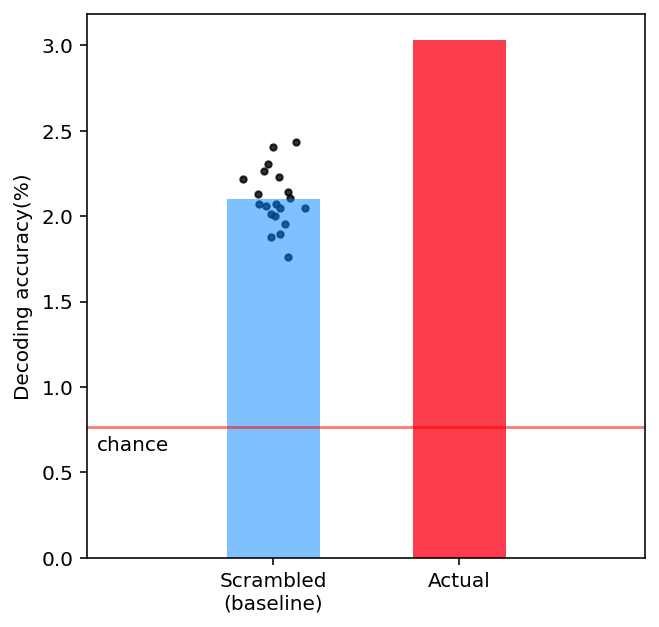

In [55]:
plt.figure(figsize=(5,5), facecolor='w')
plt.bar([1], np.mean(scram_hit_iter), width=0.5, alpha=0.5, color='#0084ff')
x_random = np.random.normal(1, 0.07, size=n_iter)
plt.scatter(x_random, np.mean(scram_hit_iter, axis=1), s=10, alpha=0.8, c='k')

plt.bar([2], np.mean(100*np.array(test_hit)/1310), width=0.5, color='#fa3c4c')
plt.xlim(0,3)
plt.axhline((n_top / 1310 * 100), c='r', alpha=0.5, label='chance')
plt.text(0+0.05,(n_top / 1310 * 100)-0.05, s='chance', ha='left', va='top')
plt.xticks([1,2], ['Scrambled\n(baseline)', 'Actual'])
plt.ylabel('Decoding accuracy(%)')

### 4-3. Decoding the representation of words in context
To improve your decoding model, you can modify the current embedding method. For example, you might think that the interpreation of the word's meaning at the current time step is affected by the words that appear at the preceding time steps. We can examine whether the decoding accuracy can be improved by considering contextual information of a word. 

In this simple example, let us consider the representation of the word at the current time as the weighted sum of the 10 consecutive previous words (including the word itself). 

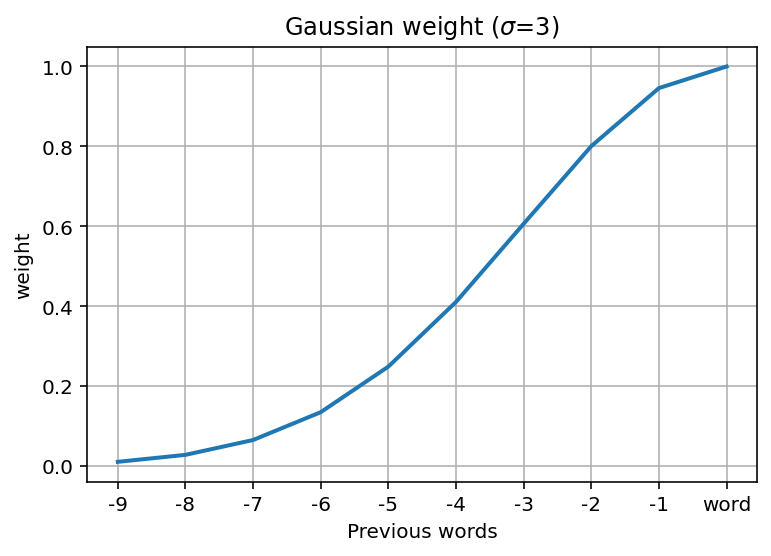

In [45]:
# We apply a Gaussian window to compute the weighted sum of the previous words
window = signal.gaussian(21, std=3)[1:11]
plt.plot(window, lw=2)
plt.title("Gaussian weight ($\sigma$=3)")
plt.ylabel("weight")
plt.xticks(np.arange(10), ['{}'.format(-10+i) for i in range(1,10)]+['word'])
plt.xlabel("Previous words")
plt.grid()

First, apply Gaussian weights to all time steps.

In [52]:
n_words = 3451
n_previous_words = 10
word_embedding_context = []
for i in range(n_words):
    if i < n_previous_words:
        weight = signal.gaussian(20, std=3)[1:11][-(i+1):]
        word_embedding_context.append(np.sum([weight[w]*word_embedding[w] for w in range(i+1)], axis=0))
    else:
        weight = signal.gaussian(20, std=3)[1:11]
        word_embedding_context.append(np.sum([weight[w]*word_embedding[i-n_previous_words+w] for w in range(n_previous_words)], axis=0))

        
word_embedding_context = np.array(word_embedding_context)
paranoia_embedding_context = np.zeros((n_TR,n_Feature))
# Downsample and convolve HRF 
for i in range(n_Feature):
    linear_downsample = interp1d(word_time, word_embedding_context[:,i])
    TR_time = np.arange(n_TR)
    downsampled_vector = linear_downsample(TR_time)
    paranoia_embedding_context[:,i] = HRFconvolve(downsampled_vector, hrf_weight)


Next, compare the weighted word vectors with the original word vectors over time.

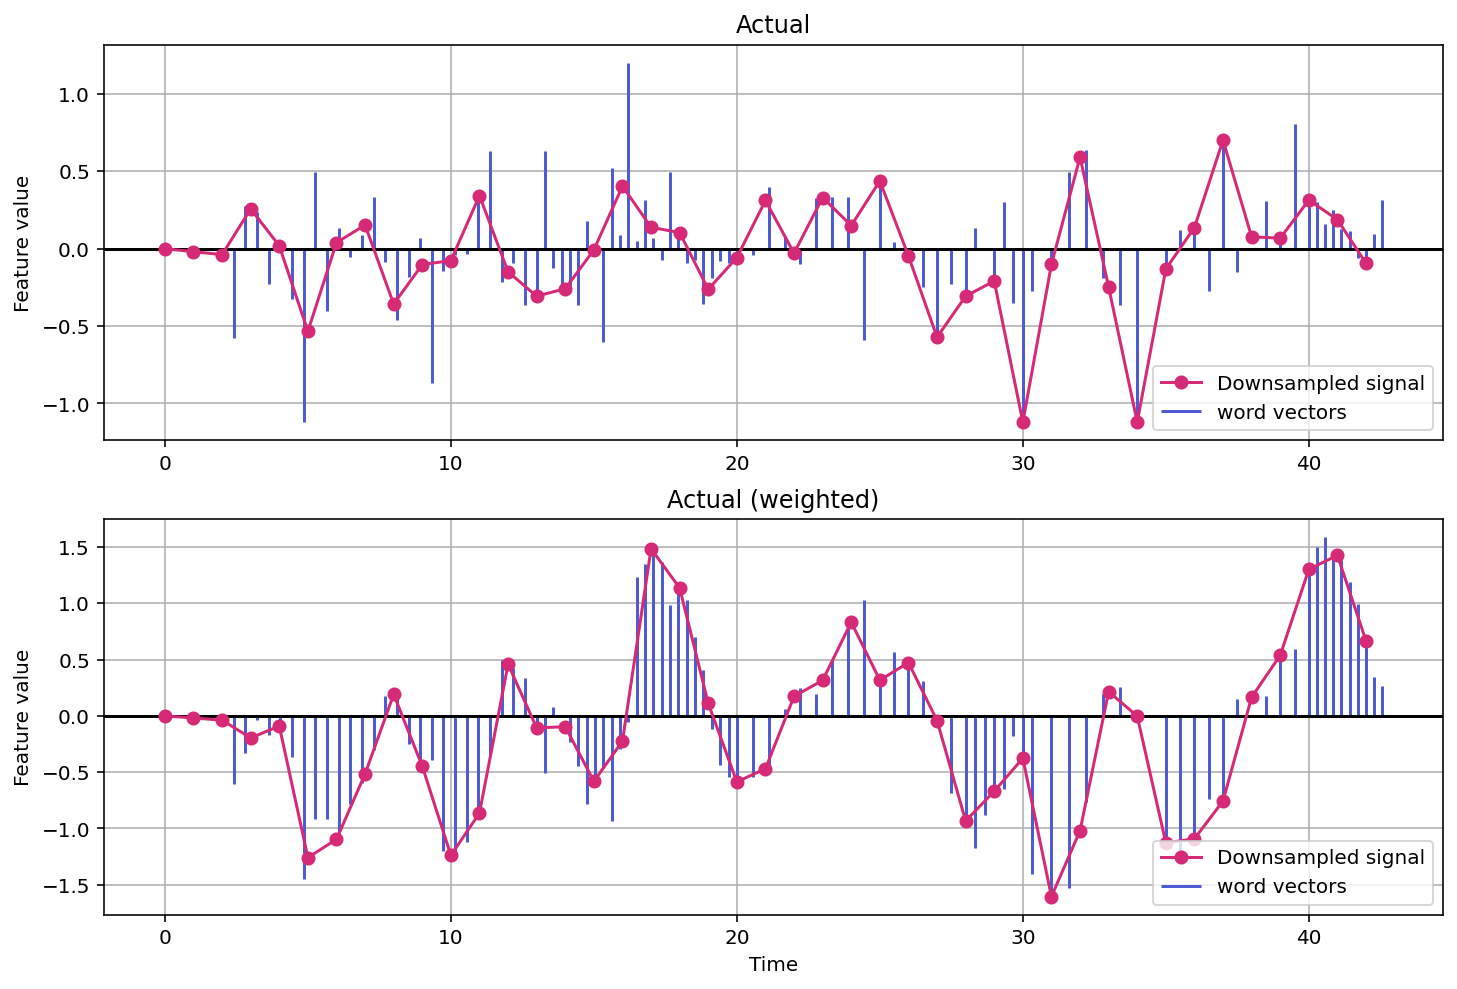

In [54]:
n_words = 100
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.axhline(0, c='k')
plt.vlines(word_time[:n_words], [0], 
           word_embedding[:n_words, feature], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_time[:n_words], 
                             word_embedding[:n_words, feature], kind='linear')

TR_time = np.arange(43) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

plt.legend(loc='lower right')
plt.ylabel('Feature value')
plt.title('Actual')
plt.grid()

plt.subplot(212)
plt.axhline(0, c='k')
plt.vlines(word_time[:n_words], [0], 
           word_embedding_context[:n_words, feature], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_time[:n_words], 
                             word_embedding_context[:n_words, feature], kind='linear')

TR_time = np.arange(43) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Feature value')
plt.title('Actual (weighted)')
plt.grid()

In [53]:
X = fmri_data
Y = zscore(paranoia_embedding_context, axis=0) # Normalize each feature dimension

n_top = 10
LOO = LeaveOneOut()

context_hit = []
# Leave one subject out cross validation
for train_index, test_index in LOO.split(sub_list):
    print("TRAIN sub:", train_index, "TEST sub:", test_index)
    X_train = np.zeros((1310*len(train_index), 246))   # Train X(fMRI): (1310*21, 246)
    y_train = np.zeros((1310*len(train_index), 100))   # Train Y(Text): (1310*21, 100)
    for i, idx in enumerate(train_index):
        X_train[i*1310:(i+1)*1310, :] = X[idx]
        y_train[i*1310:(i+1)*1310, :] = Y
    X_test = X[test_index[0]]                          # Test X(fMRI): (1310, 246)
    y_test = Y                                         # Test Y(fMRI): (1310, 246)

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    similarity = cosine_similarity(y_pred, y_test)
    
    # Check if the predicted word embedding is ranked within the top 10
    hit = 0
    for j in range(similarity.shape[0]):        
        if j in similarity[j,:].argsort()[-n_top:][::-1]:
            hit += 1
    print('Test decoding acc.: {:0.3f}%'.format(100*hit/1310))
    print(' ')

    context_hit.append(hit)
print(' ')
print('-----------------Average decoding acc. (Context)-----------------')
print('Average acc.: {:0.3f}%'.format((100*np.array(context_hit)/1310).mean()))
print('Chance acc.: {:0.3f}%'.format(n_top / 1310 * 100))

TRAIN sub: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [0]
Test decoding acc.: 5.420%
 
TRAIN sub: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [1]
Test decoding acc.: 3.664%
 
TRAIN sub: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [2]
Test decoding acc.: 2.824%
 
TRAIN sub: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [3]
Test decoding acc.: 5.191%
 
TRAIN sub: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [4]
Test decoding acc.: 4.656%
 
TRAIN sub: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [5]
Test decoding acc.: 3.359%
 
TRAIN sub: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [6]
Test decoding acc.: 2.137%
 
TRAIN sub: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [7]
Test decoding acc.: 3.664%
 
TRAIN sub: [ 0  1  2  3  4  5  6  7  9 10 11 12 

Text(0, 0.5, 'Decoding accuracy(%)')

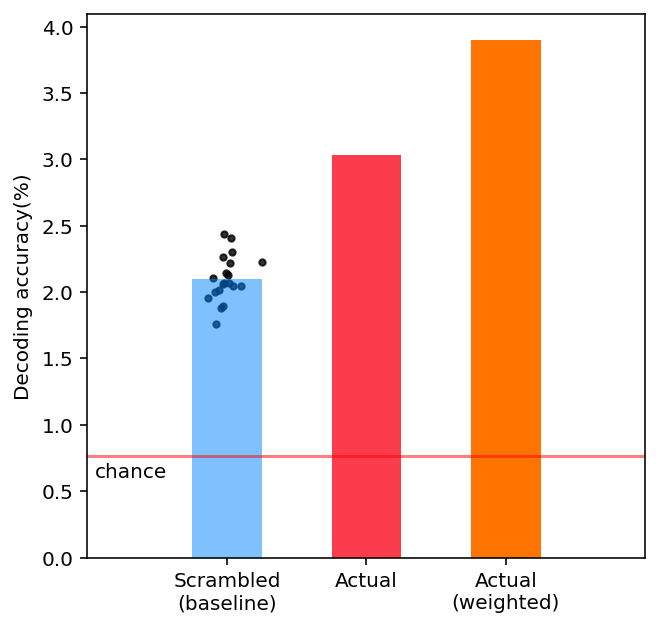

In [56]:
plt.figure(figsize=(5,5), facecolor='w')
plt.bar([1], np.mean(scram_hit_iter), width=0.5, alpha=0.5, color='#0084ff')
x_random = np.random.normal(1, 0.07, size=n_iter)
plt.scatter(x_random, np.mean(scram_hit_iter, axis=1), s=10, alpha=0.8, c='k')

plt.bar([2], np.mean(100*np.array(test_hit)/1310), width=0.5, color='#fa3c4c')
plt.bar([3], np.mean(100*np.array(context_hit)/1310), width=0.5, color='#ff7400')
plt.xlim(0,4)
plt.xticks([1,2,3], ['Scrambled\n(baseline)', 'Actual', 'Actual\n(weighted)'])
plt.axhline((n_top / 1310 * 100), c='r', alpha=0.5, label='chance')
plt.text(0+0.05,(n_top / 1310 * 100)-0.05, s='chance', ha='left', va='top')
plt.ylabel('Decoding accuracy(%)')

If you're interested in improving your model further, you can consider other embedding models that might reflect contextual information more accurately. For instance, [Jain and Huth (2018)](https://doi.org/10.1101/327601) reported encoding models that utilize contextual representations extracted from an LSTM language model. You could also try embedding models based on causal relations between events in stories. 

## 5. Visualize the weight map
This section provides an example of visualizing the weights from a linear model on top of the MNI-averaged template. Here, we visualize the regression coefficients of the first feature. 

In [46]:
BN_image = nib.load('BN_2mm.nii.gz')
BN_atlas = BN_image.get_fdata()

reg_coef = np.zeros(BN_atlas.shape)
for i in range(1,247):
    reg_coef[BN_atlas==i] = map_coef[0,i-1] # Visualize the weights of the first feature
    
reg_coef_image = nib.Nifti1Image(reg_coef, BN_image.affine, BN_image.header)


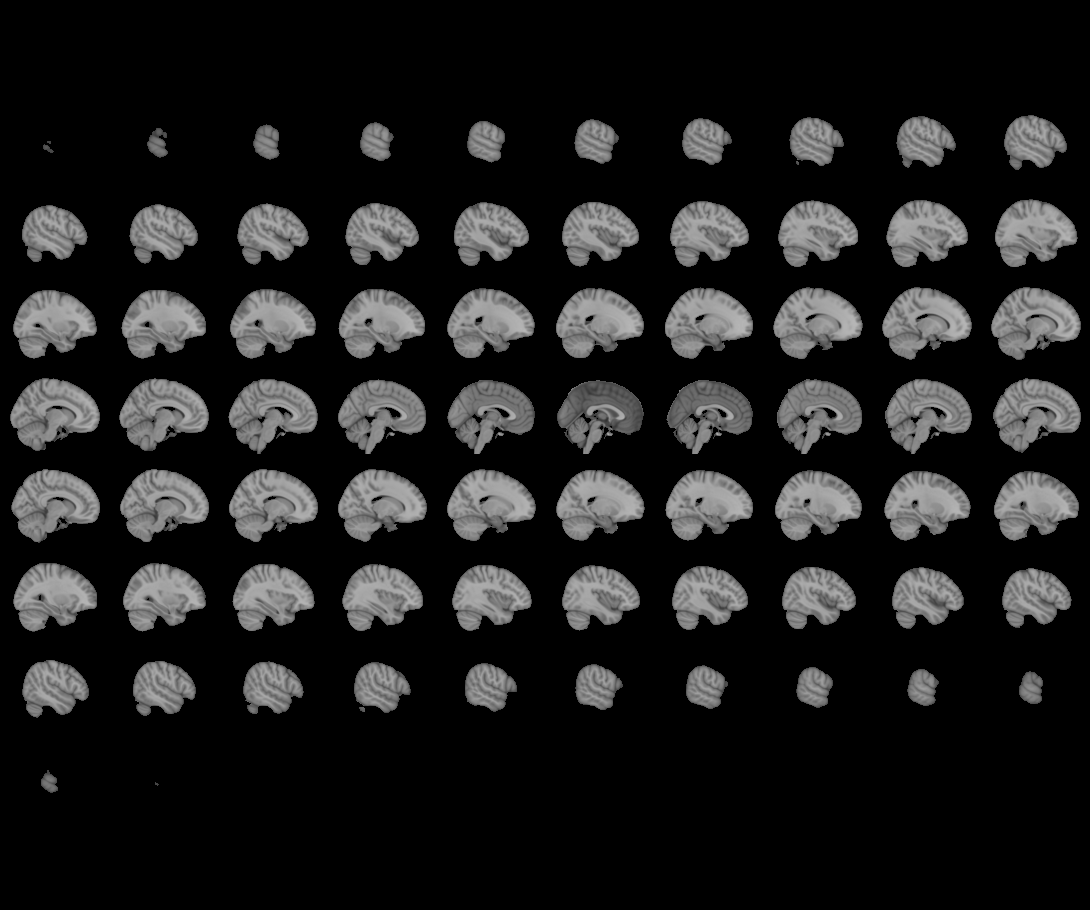
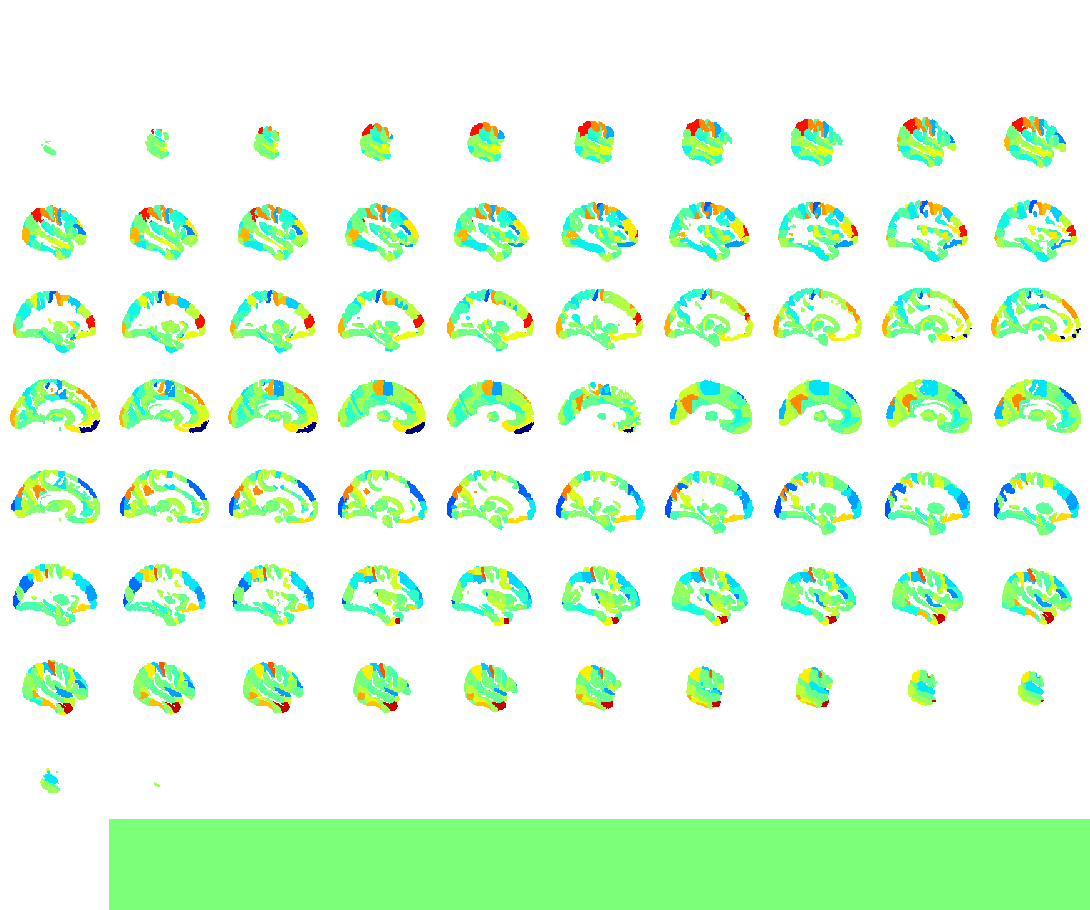

In [39]:
plotting.view_img(reg_coef_image, cmap='jet')

We can also visualize them on a surface map.

In [40]:
plotting.view_img_on_surf(reg_coef_image, cmap='jet')

## Recommended reading 
- Finn, E. S., Corlett, P. R., Chen, G., Bandettini, P. A. Constable, R. T. (2018). Trait paranoia shapes inter-subject synchrony in brain activity during an ambiguous social narrative. Nat Commun 9, 2043 .
- Huth, A. G., de Heer, W. A., Griffiths, T. L., Theunissen, F. E., Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. Nature 532, 453–458.
- Pennington, J. & Socher, R. & Manning, C. (2014). Glove: Global Vectors for Word Representation. EMNLP. 14. 1532-1543.
- Vodrahalli, K., Chen, P. -H., Liang, Y., Baldassano, C., Chen, J., Yong, E., Honey, C., Hasson, U., Ramadge, P., Norman, K. A., Arora, S. (2018). Mapping between fMRI responses to movies and their natural language annotations. NeuroImage 180, 223–231.

## Contributions
Jiwoong Park, Hayoung Song, and Won Mok Shim developed the initial notebook. 